# Clasificación de género

El objetivo del proyecto es lograr predecir el género de personas encuestadas en base a sus respuestas acecrca de:
* Color favorito
* Género de música favorito
* Bebida alcohólica favorita
* Bebida no alcohólica favorita

Se probarán los clasificadores de **Naive Bayes** y **Árbol de Decisión** y en base a los resultados se eligirá el mejor modelo entre estos. El objetivo es no solo aprender a utilizar la **librería sci-kit learn**, sino tambien lograr crear los clasificadores de manera manual.

Además se intentará juzgar si los features son buenos para lograr la clasifiación o si no permiten una clasificación óptima y se intentará escoger los features más representativos.

La justificación teórica y estadística de los algoritmos de clasificación utilizados en este notebook se puede encontrar en el archivo: Clasificadores.pdf de este mismo repositorio.

Incluyo las bibliotecas que utilizaré a lo largo del proyecto:

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OrdinalEncoder

Cargo el dataset que se utilizará:

In [2]:
datos_genero = pd.read_csv("dataset_genero.csv")

### Limpieza de datos

Voy a visualizar las dimensiones y las categorias existentes en el dataset:

In [3]:
datos_genero.shape

(66, 5)

In [4]:
datos_genero.head()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
0,Cool,Rock,Vodka,7UP/Sprite,F
1,Neutral,Hip hop,Vodka,Coca Cola/Pepsi,F
2,Warm,Rock,Wine,Coca Cola/Pepsi,F
3,Warm,Folk/Traditional,Whiskey,Fanta,F
4,Cool,Rock,Vodka,Coca Cola/Pepsi,F


Se observa que hubo 66 personas encuestadas que respondieron preguntas acerca de:
* Color favorito
* Género de música favorito
* Bebida alcohólica favorita
* Bebida no alcohólica favorita
* Género

Es un dataset pequeño

Procedo a ver si hay missing values (valores nulos o faltantes) en el dataset:

In [5]:
datos_genero.isnull().any()

Favorite Color          False
Favorite Music Genre    False
Favorite Beverage       False
Favorite Soft Drink     False
Gender                  False
dtype: bool

No hay valores nulos. Decido hacer un análisis exploratorio de los datos antes de continuar con feature engineering. Esto puede darme algun indicio de cuales features son mas relevantes y/o útiles para la clasificación.

### Análisis Exploratorio

Busco una descripción del dataset:

In [6]:
datos_genero.describe()

,Favorite Color,Favorite Music Genre,Favorite Beverage,Favorite Soft Drink,Gender
count,66,66,66,66,66
unique,3,7,6,4,2
top,Cool,Rock,Doesn't drink,Coca Cola/Pepsi,M
freq,37,19,14,32,33


Veamos que valores puede tomar cada feature o atributo:

In [7]:
datos_genero['Favorite Color'].unique().tolist()

['Cool', 'Neutral', 'Warm']

In [8]:
datos_genero["Favorite Music Genre"].unique().tolist()

['Rock',
 'Hip hop',
 'Folk/Traditional',
 'Jazz/Blues',
 'Pop',
 'Electronic',
 'R&B and soul']

In [9]:
datos_genero["Favorite Beverage"].unique().tolist()

['Vodka', 'Wine', 'Whiskey', "Doesn't drink", 'Beer', 'Other']

In [10]:
datos_genero["Favorite Soft Drink"].unique().tolist()

['7UP/Sprite', 'Coca Cola/Pepsi', 'Fanta', 'Other']

Queremos ver ahora si las clases estan desbalanceadas o no, es decir si hay mas hombres, mas mujeres o fueron encuestados en igual proporciones:

<AxesSubplot:ylabel='Gender'>

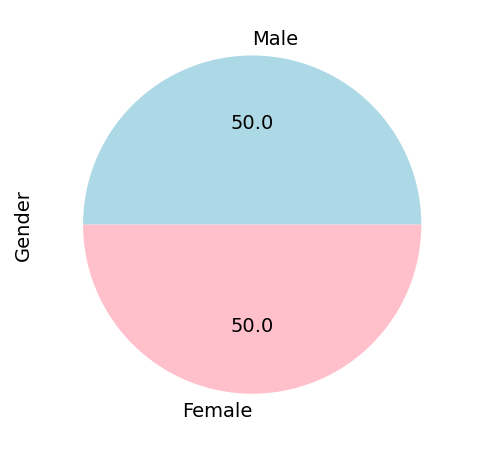

In [11]:
fig = plt.figure(dpi=140)
datos_genero["Gender"].value_counts().plot.pie(ax = plt.gca(), colors=['lightblue', 'pink'], labels=['Male', 'Female'], autopct='%.1f')

¡Hay exactamente la mitad de hombres y de mujeres! Esto permite que el accuraccy sobre el set de training pueda ser una métrica fiable y a tener en cuenta

Veamos para cada valor de cada feature, cuantos hombres y cuantas mujeres hay:

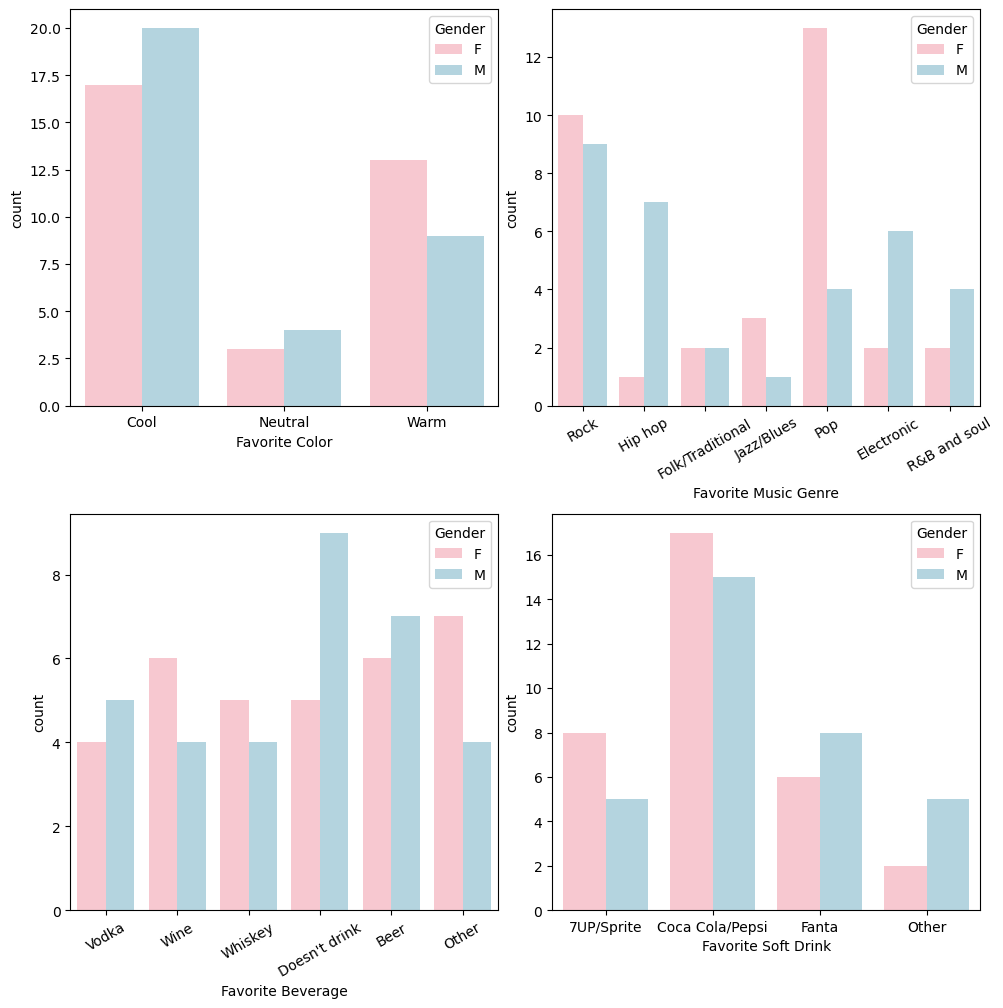

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(10,10), dpi = 100)
sns.countplot(x="Favorite Color", hue="Gender", data=datos_genero, ax=ax1, palette={"F": "pink", "M":"lightblue"})
sns.countplot(x="Favorite Music Genre", hue="Gender", data=datos_genero, ax=ax2, palette={"F": "pink", "M":"lightblue"})
sns.countplot(x="Favorite Beverage", hue="Gender", data=datos_genero, ax=ax3, palette={"F": "pink", "M":"lightblue"})
sns.countplot(x="Favorite Soft Drink", hue="Gender", data=datos_genero, ax=ax4, palette={"F": "pink", "M":"lightblue"})
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=30)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

Haccer algun analisis

# Naive Bayes

Separo la columna que quiero predecir del resto para poder luego dividir en grupo de training y de testing, además para implementar mi algoritmo de Naive Bayes necesito que las respuestas ¨Other¨ de cada categoria se diferencien por lo que las reemplazo por: ¨Other music genre¨, ¨Other soft drink¨ y ¨Other beverage¨ según corresponda.

In [13]:
genero = datos_genero["Gender"]

In [14]:
datos_genero.drop(columns = "Gender", inplace = True)

In [15]:
datos_genero["Favorite Music Genre"].replace({"Other" : "Other music genre"}, inplace = True)
datos_genero["Favorite Soft Drink"].replace({"Other" : "Other soft drink"}, inplace = True)
datos_genero["Favorite Beverage"].replace({"Other" : "Other beverage"}, inplace =  True)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(datos_genero, genero, test_size=0.4, random_state=5)

### Mi Naive Bayes
Procedo a crear un clasificador de Naive Bayes de manera manual

In [17]:
probabilidades_a_priori_genero = y_train.value_counts(normalize = True)

probabilidad_a_priori_ser_hombre = probabilidades_a_priori_genero.loc["M"] 
probabilidad_a_priori_ser_mujer = probabilidades_a_priori_genero.loc["F"] 

probabilidades_a_priori_mujer = pd.Series(dtype='float64')
probabilidades_a_priori_hombre = pd.Series(dtype='float64')

y_pred = []

for column in X_train.columns:
    probabilidades_a_priori_hombre = pd.concat([probabilidades_a_priori_hombre, X_train.loc[y_train[y_train == 'M'].index][column].value_counts(normalize = True)])
    probabilidades_a_priori_mujer = pd.concat([probabilidades_a_priori_mujer, X_train.loc[y_train[y_train == 'F'].index][column].value_counts(normalize = True)])

for encuestado in X_test.index:
    preguntas = X_test.loc[encuestado]
    probabilidad_a_posteriori_ser_hombre = probabilidad_a_priori_ser_hombre
    probabilidad_a_posteriori_ser_mujer = probabilidad_a_priori_ser_mujer

    for pregunta in preguntas.index:
        respuesta = preguntas.loc[pregunta]
        try:
            probabilidad_feature_hombre = probabilidades_a_priori_hombre.loc[respuesta]
        except:
            probabilidad_feature_hombre = 0
        
        try:
            probabilidad_feature_mujer = probabilidades_a_priori_mujer.loc[respuesta]
        except:
            probabilidad_feature_mujer = 0
            
        probabilidad_a_posteriori_ser_hombre *= probabilidad_feature_hombre
        probabilidad_a_posteriori_ser_mujer *= probabilidad_feature_mujer
        
    if(probabilidad_a_posteriori_ser_hombre > probabilidad_a_posteriori_ser_mujer):
        y_pred.append("M")
    else:
        y_pred.append("F")
    
print(f"Porcentaje de accuracy en el set de testing: {(y_test == y_pred).mean()} ")

Porcentaje de accuracy en el set de testing: 0.5555555555555556 


### Categorical Naive Bayes de Sci-Kit Learn
Procedo a utilizar el clasificador de Naive Bayes que provee la libreria Sci-Kit Learn:

In [18]:
gnb = CategoricalNB(alpha = 0.0000000001)

enc = OrdinalEncoder()

enc.fit(X_train)
X_train = enc.transform(X_train)

X_test = enc.transform(X_test)

y_pred_NB = gnb.fit(X_train, y_train).predict(X_test)
print(f"Porcentaje de accuracy en el set de testing: {(y_test == y_pred_NB).mean()} ")

Porcentaje de accuracy en el set de testing: 0.5555555555555556 


### Comparando los resiltados:

In [19]:
y_pred == y_pred_NB

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

¡Observamos que el clasificador creado coincide perfectamente con el de Sci-Kit Learn! Sin embargo, las predicciones hechas con ambos no son muy buenas, hay un 55% de accuracy sobre el set de datos.

### Matriz de confusión

Haré una matriz de confusión para ver si el problema es que predigo que muchas personas son hombres o que muchas personas son mujeres, o ambos:

In [20]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

Text(69.58333333333334, 0.5, 'Real')

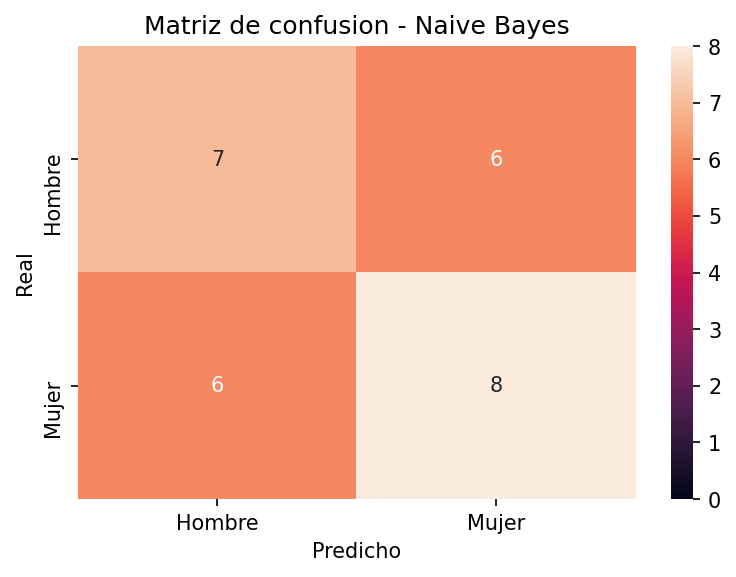

In [21]:
fig, ax = plt.subplots(dpi =150)   
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, vmin = 0, yticklabels=["Hombre","Mujer"], xticklabels=["Hombre", "Mujer"], ax=ax)
ax.set_title("Matriz de confusion - Naive Bayes")
ax.set_xlabel("Predicho")
ax.set_ylabel("Real")

Puedo ver que la matriz de confusión no es buena a simple vista. Lo ideal sería que tuviera valores altos en la diagonal principal y valores bajos en la diagonal invertida, sin embargo se observa que los valores son muy similares en ambas diagonales.

Podemos decir también que el error en las predicciones de hombres es igual al error en las predicciones de mujeres: se predijeron la misma cantidad de hombres equivocadamente que de mujeres (6).

# Árbol de decisión

### Decision Tree Classifier de Sci-Kit learn

El clasificador de árbol de decisión de la librería sci-kit learn requiere que antes de realizar el entrenamiento se utilice One Hot Encoding para trabajar con las variables categóricas, por lo tanto importamos las librerías necesarias:

In [22]:
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier

Realizamos un LabelEncoding sobre la variable objetivo y un OHE sobre el dataset:

In [98]:
datos_genero_OHE = pd.get_dummies(datos_genero, drop_first=True, columns=datos_genero.columns)

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(genero)
genero_encodeado = label_encoder.transform(genero)

El resultado del OHE es el siguiente:

In [99]:
datos_genero_OHE.head()

,Favorite Color_Neutral,Favorite Color_Warm,Favorite Music Genre_Folk/Traditional,Favorite Music Genre_Hip hop,Favorite Music Genre_Jazz/Blues,Favorite Music Genre_Pop,Favorite Music Genre_R&B and soul,Favorite Music Genre_Rock,Favorite Beverage_Doesn't drink,Favorite Beverage_Other beverage,Favorite Beverage_Vodka,Favorite Beverage_Whiskey,Favorite Beverage_Wine,Favorite Soft Drink_Coca Cola/Pepsi,Favorite Soft Drink_Fanta,Favorite Soft Drink_Other soft drink
0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0
3,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0


Procedo a realizar la división en datos de entrenamiento y en datos de validación o testing:

In [47]:
X_train, X_test, y_train, y_test = train_test_split(datos_genero_OHE, genero_encodeado, test_size=0.4, random_state=5)

Entreno el arbol cuya profundidad máxima quiero que sea 3, el objetivo de esto es que no overfitee los datos de entrenamiento y ganar generalidad.

In [96]:
clf = tree.DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(X_train, y_train)

Exportamos el árbol y lo graficamos para visualizarlo:

In [97]:
import graphviz 
dot_data = tree.export_graphviz(clf, feature_names=datos_genero_OHE.columns.to_list(),  class_names=["Female","Male"],  max_depth = 3) 
graph = graphviz.Source(dot_data) 
graph.render("arbol de decision") 

'arbol de decision.pdf'

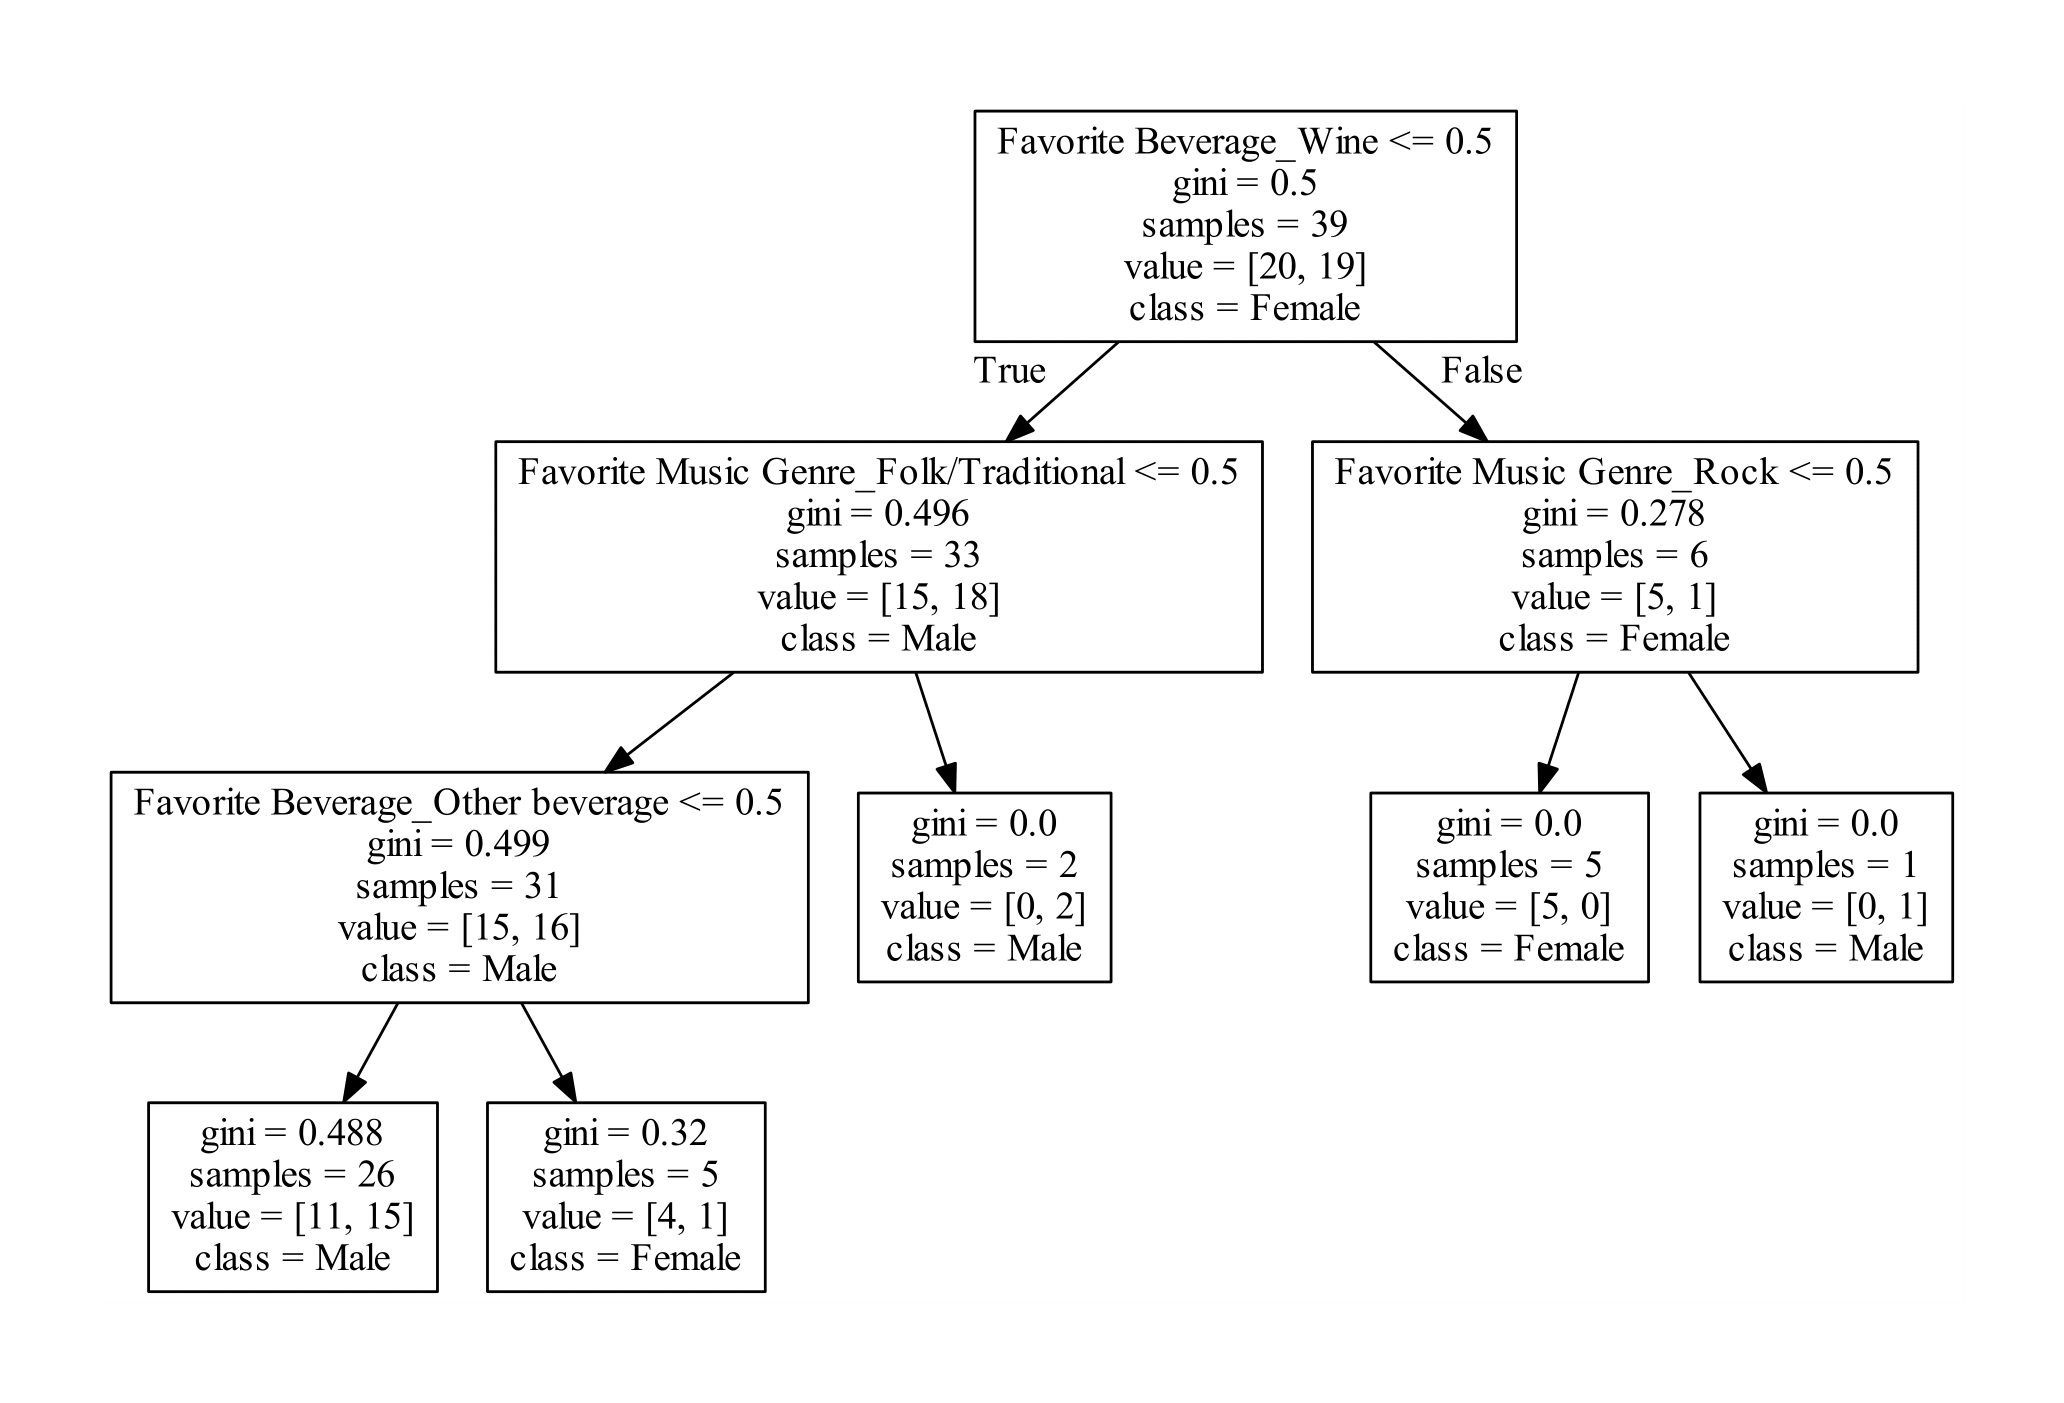

In [5]:
from IPython.display import Image
Image("arbol de decision.png")

Ahora procedamos a ver el accuracy sobre el set de testing:

In [57]:
(clf.predict(X_test) == y_test).mean()

0.5925925925925926

¡Es mejor que en el clasificador de Naive Bayes! Aunque por muy poco

### Mi árbol de decisión

Mi idea es construir un árbol de decisión en base al criterio de Gini para elegir el feature a agregar en un nodo.